In [1]:
import os,sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append('..')
from datasets import load_dataset, Audio
from transformers import AutoProcessor
from utils.utils import *

In [2]:
# ==============================================================================
# process data
# ==============================================================================
minds = load_dataset("PolyAI/minds14", name="en-US", split="train[:100]")
minds = minds.train_test_split(test_size=0.2)
minds = minds.remove_columns(["english_transcription", "intent_class", "lang_id"])

print(minds["train"][0])

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))
minds["train"][0]

processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base")

def uppercase(example):
    return {"transcription": example["transcription"].upper()}

def prepare_dataset(batch):
    audio = batch["audio"]
    batch = processor(audio["array"], sampling_rate=audio["sampling_rate"], text=batch["transcription"])
    batch["input_length"] = len(batch["input_values"][0])
    return batch

minds = minds.map(uppercase)

encoded_minds = minds.map(prepare_dataset, remove_columns=minds.column_names["train"], num_proc=4)

{'path': '/tmp/xdg_cache_f006pq6/huggingface/datasets/downloads/extracted/3d9dda5a74ce5998885ee464e861ffd2f8072c556851418d0e1f21b0735c7ec4/en-US~PAY_BILL/602b9dff963e11ccd901cc1d.wav', 'audio': {'path': '/tmp/xdg_cache_f006pq6/huggingface/datasets/downloads/extracted/3d9dda5a74ce5998885ee464e861ffd2f8072c556851418d0e1f21b0735c7ec4/en-US~PAY_BILL/602b9dff963e11ccd901cc1d.wav', 'array': array([0.        , 0.        , 0.00024414, ..., 0.        , 0.        ,
       0.        ]), 'sampling_rate': 8000}, 'transcription': 'teach me how to pay bill online'}
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


/scratch/f006pq6/bin/miniconda3/envs/asr_reveal/lib/python3.9/site-packages/transformers/configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/80 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/20 [00:00<?, ? examples/s]

In [3]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union


@dataclass
class DataCollatorCTCWithPadding:
    processor: AutoProcessor
    padding: Union[bool, str] = "longest"

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"][0]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(input_features, padding=self.padding, return_tensors="pt")

        labels_batch = self.processor.pad(labels=label_features, padding=self.padding, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch
data_collator = DataCollatorCTCWithPadding(processor=processor, padding="longest")

In [4]:
# ==============================================================================
# metrics for ASR task
# ==============================================================================
import evaluate
import numpy as np
wer = evaluate.load("wer")


def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [5]:
# ==============================================================================
# Load the Wav2vec2 models. two cases: use pretrained weight or just the model skeleton 
# ==============================================================================
from transformers import AutoModelForCTC, TrainingArguments, Trainer, AutoConfig

# ==============================================================================
# Using pretrained weight

# model = AutoModelForCTC.from_pretrained(
#     "facebook/wav2vec2-base",
#     ctc_loss_reduction="mean",
#     pad_token_id=processor.tokenizer.pad_token_id,
# )
# ==============================================================================
# Using untrained model
config = AutoConfig.from_pretrained("facebook/wav2vec2-base",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id)

model = AutoModelForCTC.from_config(config)
model = model.train()
print(model.config)
# for param in model.parameters():
#     if param.requires_grad == False:
#         print(param)

/scratch/f006pq6/bin/miniconda3/envs/asr_reveal/lib/python3.9/site-packages/transformers/configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Wav2Vec2Config {
  "_name_or_path": "facebook/wav2vec2-base",
  "activation_dropout": 0.0,
  "adapter_attn_dim": null,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForPreTraining"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "mean",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": false,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_norm": "group",
  "feat_proj_dropout": 0.1,
  "feat_quantizer_dropout": 0.0,
  "final_dropout": 0.0,
  "freeze_feat_extract_

In [6]:
# ==============================================================================
# training params, only change is to set batch_size=1
# 
# ==============================================================================
training_args = TrainingArguments(
    output_dir="my_awesome_asr_mind_model",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=2000,
    gradient_checkpointing=True,
    fp16=True,
    group_by_length=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_minds["train"],
    eval_dataset=encoded_minds["test"],
    tokenizer=processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# trainer.train()

In [7]:
# ==============================================================================
#  get a data sample to work on
# ==============================================================================
train_dataloader = trainer.get_train_dataloader()
for sample in train_dataloader:
    break
x_input = sample['input_values']
print(x_input.shape) # [ 1,51882]
x_input = x_input[:,30000:50000]
print(x_input.shape) # [ 1,51882]

torch.Size([1, 187050])
torch.Size([1, 20000])


/scratch/f006pq6/bin/miniconda3/envs/asr_reveal/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


torch.Size([1, 62, 32])


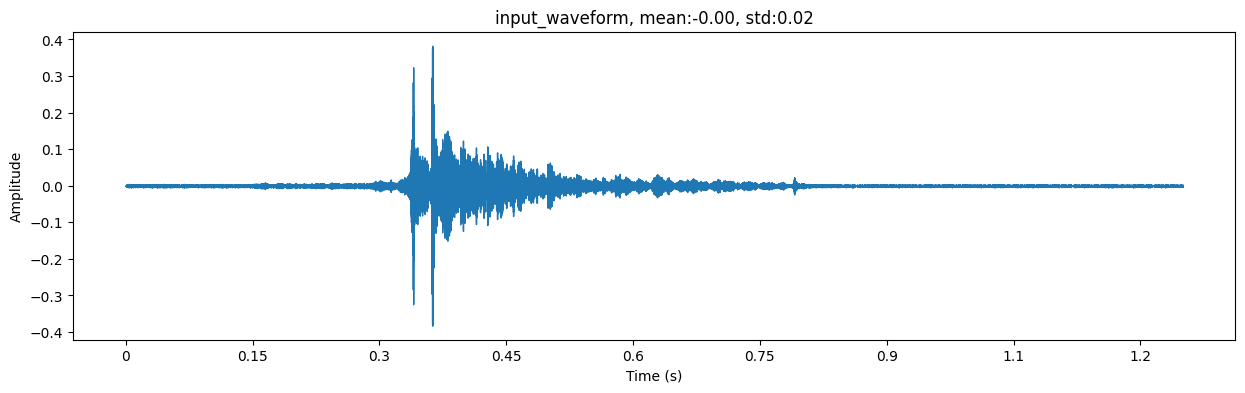

In [8]:
# ==============================================================================
# run the input to model, print out shape 
# ==============================================================================
y = model(x_input)
print(y.logits.shape)
plot_waveform(x_input.cpu().detach().numpy(), 16_000,"input_waveform, mean:{:.2f}, std:{:.2f}".format(x_input.mean().item(), x_input.std().item()))

# ==============================================================================
# make target same length with inputs to use cross entr loss
device = y.logits.device
targets = torch.randint(low=1, high=32, size = (1,y.logits.shape[1])).to(device)
target_sizes = torch.tensor([targets.shape[1]]).to(device)



In [9]:

# ------------------------------------------------------------------------------
#  Loss function, get target dL/dW
# ------------------------------------------------------------------------------
##get the param to match gradient
weight_param =  model.lm_head.weight
print('weigth_param shape:', weight_param.shape)

y = model(x_input) 
y     = y.logits # 1 405 32


# ==============================================================================
# if ctc
# out = out.transpose(0, 1)  # TxNxH
# out = out.log_softmax(-1) # if model in train, use log_softmax. else use log
# from torch.nn import CTCLoss
# loss_ = CTCLoss(blank=model_ds.labels.index('_'), reduction='sum', zero_infinity=True)(out, targets, output_sizes, target_sizes)


# ==============================================================================
# make output sizes equal output of network
# make random target size equal size of output
# output_sizes = torch.tensor([out.shape[0]])
# loss_func = lambda x,y :ctc_loss_imp(x, y, output_sizes, target_sizes,reduction='sum')

# ==============================================================================
# if crossentropy
y = y.squeeze() #405 x 32
targets = targets.squeeze() # [405]

loss_func   = torch.nn.CrossEntropyLoss()
# ==============================================================================

loss = loss_func(y, targets)
# print(loss.item(), loss_.item())
# grab gradient to match
dldw_target= torch.autograd.grad(loss, weight_param)[0]

print('grad shape:',dldw_target.shape, 'grad_norm', dldw_target.norm())


weigth_param shape: torch.Size([32, 768])
grad shape: torch.Size([32, 768]) grad_norm tensor(3.3467, device='cuda:0')


In [10]:
# ------------------------------------------------------------------------------
# Meta loss
# ------------------------------------------------------------------------------
def meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param):
    loss = loss_func(output, targets)
    dldw = torch.autograd.grad(loss, weight_param, create_graph=True)[0]
    mse_loss = ((dldw-dldw_target)**2).sum()
    return mse_loss,dldw

# ------------------------------------------------------------------------------
# Init random input
# ------------------------------------------------------------------------------

x_hat = torch.nn.Parameter(torch.rand_like(x_input).to(device),requires_grad=True)

In [11]:
x_hat.norm()

tensor(81.3769, device='cuda:0', grad_fn=<NormBackward1>)

In [12]:
# ------------------------------------------------------------------------------
# Train
# ------------------------------------------------------------------------------
import torch.optim as optim

optimizer = optim.Adam([x_hat], lr=.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=.5,patience=100)

i=0
loss_history = []
while True:

    output = model(x_hat) # 1 176 29
    y_hat  = output.logits
    # output, output_sizes, _= model_ds(x_hat, input_sizes) # 1 176 29
    # ==============================================================================
    # if crossentropy
    y_hat = y_hat.squeeze()

    # ==============================================================================
    # if ctc
    # output = output.transpose(0, 1)  # TxNxH
    # output = output.log_softmax(-1) # if in training mode
    # output = output.log() # if in eval mode (deepspeech model already output softmax)

    # ==============================================================================

    # mloss, dldw_f = meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param)
    mloss, dldw_f = meta_loss(output=y_hat, targets=targets, output_sizes=None,
                              target_sizes =  None, dldw_target=dldw_target,  weight_param=weight_param)

    # add L1 regularization
    # mloss += .01 * torch.sum(torch.abs(x_hat)) + .01 * torch.mean(x_hat**2)
    # mloss +=  .01 * torch.mean(x_hat**2)
    optimizer.zero_grad()
    mloss.backward()
    grad = x_hat.grad.data

    optimizer.step()

    loss_history.append(mloss.item())

    if i % 10 == 0:
        print('Iteration, Loss, Gradient Norm, Learning Rate: {:4d}, {:.4f}, {:.4f}, {:.4f}'.format(i, mloss.item(), grad.norm().item(), optimizer.param_groups[0]["lr"]))
        scheduler.step(mloss.item())

    if (i+ 1) % 10000 == 0:
        torch.save({
            'model':model.state_dict(),
            'loss_history': loss_history,
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
             }, f'model_checkpoint_{i+ 1}.pt')
        print(f'Model saved at iteration {i+ 1}')


    i+=1

Iteration, Loss, Gradient Norm, Learning Rate:    0, 15.3175, 1.2109, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   10, 10.5073, 0.3634, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   20, 8.2486, 0.2785, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   30, 7.6479, 0.2187, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   40, 8.0916, 0.1872, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   50, 7.7047, 0.2219, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   60, 7.5245, 0.1959, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   70, 7.3206, 0.1825, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   80, 8.5854, 0.1960, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   90, 7.1436, 0.1813, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  100, 8.5482, 0.1849, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  110, 6.6191, 0.1754, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  120, 6.9153, 0.1647, 0.1000
Iteration,

KeyboardInterrupt: 

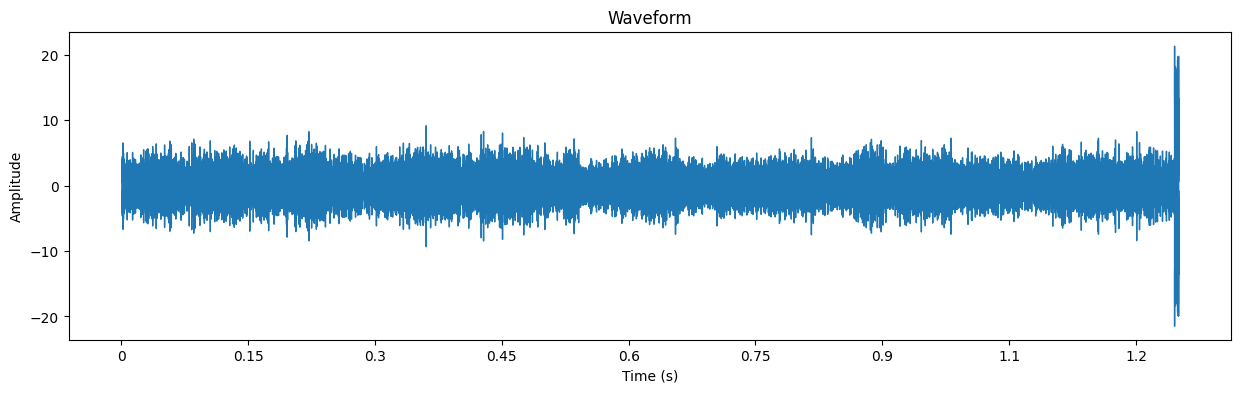

In [13]:
plot_waveform(x_hat.detach().cpu().numpy(),sr=16_000)

In [ ]:
.35

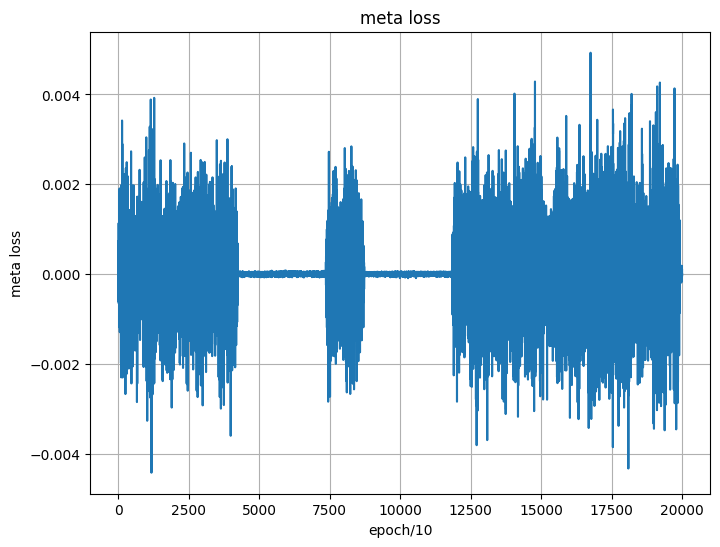

In [27]:
plot_loss_over_epoch(grad.squeeze().tolist(), 'meta loss','epoch/10','meta loss')

In [26]:
grad.squeeze().tolist()

[1.3141169802111108e-05,
 0.0003056588175240904,
 -8.424338739132509e-05,
 -0.0006054174737073481,
 -0.00046414867392741144,
 -1.0621442925184965e-06,
 -0.00031381973531097174,
 0.0011341022327542305,
 0.00044127035653218627,
 -0.0006508733495138586,
 -0.0003091478138230741,
 0.0006197284674271941,
 0.0005895926151424646,
 -8.564064046368003e-06,
 0.0003501328465063125,
 0.00025612732861191034,
 0.0007534453179687262,
 -0.00011163254384882748,
 0.0005659975577145815,
 0.00013294110249262303,
 -0.000441000796854496,
 0.0006171074346639216,
 0.000190568040125072,
 3.740289685083553e-05,
 7.506272231694311e-05,
 -0.0010806097416207194,
 -0.0006950396345928311,
 0.0001670177443884313,
 -0.0010365416528657079,
 -3.069017839152366e-05,
 0.0018098338041454554,
 -0.00042476056842133403,
 -0.0005028905579820275,
 -0.00019222634728066623,
 0.0015848692273721099,
 -2.1072941308375448e-05,
 -0.0001903191878227517,
 0.0004873179132118821,
 0.0002830339362844825,
 0.0019061786588281393,
 0.001054660

In [24]:
loss_history

AttributeError: 'list' object has no attribute 'shape'